In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
names = [
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
    "ten",
    "eleven",
    "twelve",
    "thirteen",
    "fourteen",
    "fifteen",
    "sixteen",
]
number_of_layers = 7  # np.random.randint(0,15)
neighbors = np.random.randint(1, 200)
df = pd.DataFrame()

# this section builds some toy data with an angular unconformity
for j in np.arange(3, 5.5, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = (
        3 * np.sin(np.arange(0, 20, 0.1) / 6.28) + np.random.rand(200) / 100
    )
    for i in range(len(names[0:number_of_layers])):
        layer_elevation = 3 * np.sin(
            np.arange(0, 20, 0.1) / 6.28
        ) + np.random.uniform(0, j)
        elevation = np.full(200, j) + np.random.rand(200) / 100
        layer_elevation = (
            np.where(layer_elevation > elevation, elevation, layer_elevation)
            + np.random.rand(200) / 100
        )
        rolling[names[i]] = layer_elevation
    for k in range(150):
        rolling.iloc[
            np.random.randint(0, 199),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    df = pd.concat((df, rolling))
angular_thicknesses = df.T.diff(axis=0).abs().T
# neigh = angular_thicknesses.shift(neighbors)
logged = angular_thicknesses.apply(np.log)
powered = angular_thicknesses.apply(lambda x: x ** 10)
angular_thicknesses = (
    pd.concat(
        [angular_thicknesses, logged, powered],
        axis=1,
        join_axes=[angular_thicknesses.index],
    )
    .drop(columns=["zero"])
    .dropna()
    .replace(-np.inf, 0)
)

# now for onlap section
df_onlap = pd.DataFrame()

for j in np.arange(3, 5.5, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = 3 * np.sin(np.arange(0, 20, 0.1) / 6.28)
    for i in range(len(names[0:number_of_layers])):
        zero = (
            3 * np.sin(np.arange(0, 20, 0.1) / 6.28)
            + np.random.rand(200) / 100
        )
        randomness = np.random.uniform(0, j)
        elevation = np.full(200, j) + np.random.rand(200) / 100
        onlap = np.where(
            np.full(200, randomness) > zero,
            np.full(200, randomness) + np.random.rand(200) / 100,
            zero,
        )
        layer_elevation = np.where(onlap > elevation, elevation, onlap)
        rolling[names[i]] = layer_elevation
    for k in range(150):
        rolling.iloc[
            np.random.randint(0, 199),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    df_onlap = pd.concat((df_onlap, rolling))
onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
# neigh = onlap_thicknesses.shift(neighbors)
logged = onlap_thicknesses.apply(np.log)
powered = onlap_thicknesses.apply(lambda x: x ** 10)
onlap_thicknesses = (
    pd.concat(
        [onlap_thicknesses, logged, powered],
        axis=1,
        join_axes=[onlap_thicknesses.index],
    )
    .drop(columns=["zero"])
    .dropna()
    .replace(-np.inf, 0)
)

# now for horizontal stratification

df_horizontal = pd.DataFrame()

for j in np.arange(3, 5.5, 0.1):
    rolling = pd.DataFrame()
    rolling["zero"] = np.full(200, 0) - np.random.rand(200) / 100
    for i in range(len(names[0:number_of_layers])):
        randomness = np.random.uniform(0, j)
        elevation = np.full(200, j) + np.random.rand(200) / 100
        horiz = np.full(200, randomness)
        layer_elevation = np.where(horiz > elevation, elevation, horiz)
        rolling[names[i]] = layer_elevation
    for k in range(150):
        rolling.iloc[
            np.random.randint(0, 199),
            np.random.randint(0, number_of_layers - 1),
        ] = 0
    df_horizontal = pd.concat((df_horizontal, rolling))
horizontal_thicknesses = df_horizontal.T.diff(axis=0).abs().T
# neigh = horizontal_thicknesses.shift(neighbors)
logged = horizontal_thicknesses.apply(np.log)
powered = horizontal_thicknesses.apply(lambda x: x ** 10)

horizontal_thicknesses = (
    pd.concat(
        [horizontal_thicknesses, logged, powered],
        axis=1,
        join_axes=[horizontal_thicknesses.index],
    )
    .drop(columns=["zero"])
    .dropna()
    .replace(-np.inf, 0)
)

# normalize the data
normalized_df = (angular_thicknesses - angular_thicknesses.min()) / (
    angular_thicknesses.max() - angular_thicknesses.min()
).replace(0, 0.00001)
normalized_dfo = (onlap_thicknesses - onlap_thicknesses.min()) / (
    onlap_thicknesses.max() - onlap_thicknesses.min()
).replace(0, 0.00001)
normalized_dfh = (horizontal_thicknesses - horizontal_thicknesses.min()) / (
    horizontal_thicknesses.max() - horizontal_thicknesses.min()
).replace(0, 0.00001)
normalized_dfo["class"] = 1
normalized_df["class"] = 0
# normalized_dfh['class'] = 2

# merge into new dataset
dataset = pd.concat((normalized_df, normalized_dfo))

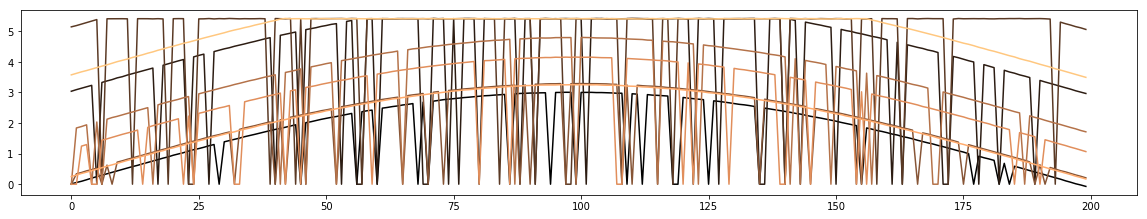

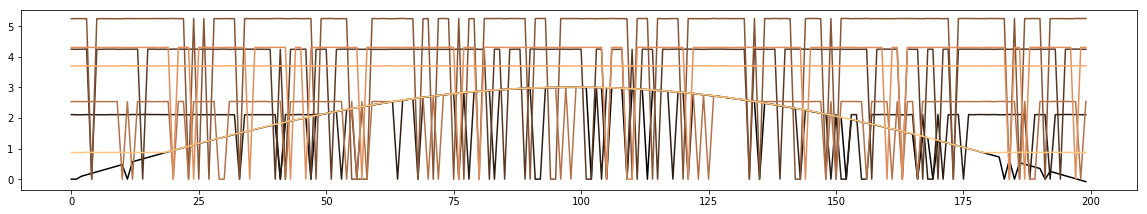

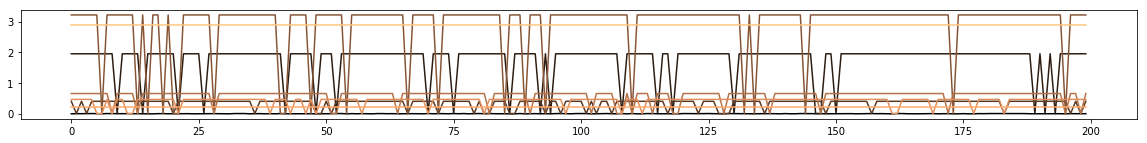

In [3]:
# now let's visualize what the stratigraphy looks like for our toy training data
df.iloc[-200:].plot(legend=False, figsize=(20, 10), cmap="copper").set_aspect(
    6
)
df_onlap.iloc[-200:].plot(
    legend=False, figsize=(20, 10), cmap="copper"
).set_aspect(6)
# df_horizontal.iloc[1200:1400].plot(legend=False, figsize=(20,10), cmap='copper').set_aspect(6)

In [4]:
from sklearn.model_selection import train_test_split

# next let's split our toy data into training and test sets, 10% of the data becomes the test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[0:, 0:-1].values,
    dataset.iloc[0:, -1].values,
    test_size=0.5,
    random_state=86,
)

In [5]:
from keras.utils import to_categorical

y_train_encoded = to_categorical(
    y_train
)  # this converts the target variable to one-hot encoding
y_test_encoded = to_categorical(
    y_test
)  # same with the test data conversion to one-hot encoding

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# Import keras and some layers, we are going to build a network with two dense layers and a dropout layer
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [7]:
# this is the network, we initialize with a dense layer and a relu activation
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.5))  # dropout to avoid overfitting
model.add(
    Dense(2, kernel_initializer="random_uniform", activation="sigmoid")
)  # and another dense layer with sigmoid activation

In [8]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="nadam",
    metrics=["categorical_accuracy"],
)
# builds the model, with categorical crossentropy for our loss function, optimizing using nadam, and using categorical accuracy
# as our accuracy metric

In [21]:
model.fit(
    X_train, y_train_encoded, epochs=60, batch_size=32
)  # Fitting the model for 50 epochs and batch size of 32

Epoch 1/60
5000/5000 [==============================] - 0s 40us/step - loss: 0.4497 - categorical_accuracy: 0.7928
Epoch 2/60
5000/5000 [==============================] - 0s 38us/step - loss: 0.4405 - categorical_accuracy: 0.7954
Epoch 3/60
5000/5000 [==============================] - 0s 39us/step - loss: 0.4312 - categorical_accuracy: 0.7918
Epoch 4/60
5000/5000 [==============================] - 0s 39us/step - loss: 0.4263 - categorical_accuracy: 0.8048
Epoch 5/60
5000/5000 [==============================] - 0s 38us/step - loss: 0.4196 - categorical_accuracy: 0.8066
Epoch 6/60
5000/5000 [==============================] - 0s 38us/step - loss: 0.4006 - categorical_accuracy: 0.8196
Epoch 7/60
5000/5000 [==============================] - 0s 43us/step - loss: 0.4055 - categorical_accuracy: 0.8122
Epoch 8/60
5000/5000 [==============================] - 0s 38us/step - loss: 0.4018 - categorical_accuracy: 0.8138
Epoch 9/60
5000/5000 [==============================] - 0s 38us/step - loss: 0.3

In [22]:
score = model.evaluate(
    X_test, y_test_encoded
)  # tests the model on the test data
score

5000/5000 [==============================] - 0s 19us/step


[0.1940681181192398, 0.9446]

In [23]:
preds = model.predict(
    X_test
)  # creates predictions on the test data that we can use

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


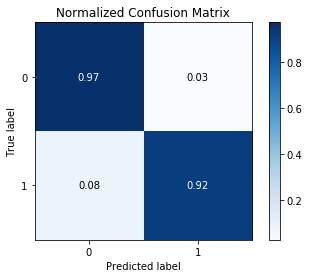

In [24]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, np.argmax(preds, axis=1), normalize=True
)  # let's visualize the predictions

In [25]:
tops = pd.read_csv(r"D:\GRBwtoe.csv").fillna(0)
tops

,API,Latitude,Longitude,KB,GL,TD,Field,Formation_TD,Fox_Hills,Lewis,Almond,Ericson,Rock_Springs,Blair,Baxter,Frontier
0,3720898,41.64954,-108.79645,6670,6654,6617,Shiprock,Frontier,0,0,0.0,0.0,855.0,2050.0,3005.0,6285.0
1,3705616,41.62957,-108.67895,6681,6671,5135,0,Baxter,0,0,1205.0,1547.0,2565.0,4250.0,5010.0,0.0
2,3705564,41.60755,-108.51992,6747,6734,4710,Arch,Almond,3224,3498,4635.0,0.0,0.0,0.0,0.0,0.0
3,3723434,42.04156,-108.38434,6837,6821,10435,Hay Reservoir,Lewis,9105,9330,0.0,0.0,0.0,0.0,0.0,0.0
4,3720835,41.53297,-108.17385,7092,7078,12768,Wells Bluff,Rock Springs,8631,8770,10854.0,11292.0,11635.0,0.0,0.0,0.0
5,3721121,41.51786,-108.15494,7007,6992,11703,Wells Bluff,Rock Springs,8410,8709,10816.0,11230.0,11308.0,0.0,0.0,0.0
6,3721192,41.48193,-108.05939,6819,6804,11235,Wild Rose,Ericson,8358,8550,10677.0,11151.0,0.0,0.0,0.0,0.0
7,3721407,41.47498,-108.00095,6696,6680,10661,Wild Rose,Rock Springs,7563,7795,10033.0,10472.0,10647.0,0.0,0.0,0.0
8,721369,41.45313,-107.89628,6623,6607,9550,Wild Rose,0,6512,6795,9027.0,9538.0,0.0,0.0,0.0,0.0
9,720757,41.44524,-107.80960,6821,6806,9130,Baldy Butte,Rock Springs,5678,6030,8294.0,8725.0,8885.0,0.0,0.0,0.0


In [26]:
tops2 = tops[tops.columns[8:]].T.diff().T.drop(columns=["Fox_Hills"])
tops2[tops2 < 0] = 0
tops2

,Lewis,Almond,Ericson,Rock_Springs,Blair,Baxter,Frontier
0,0.0,0.0,0.0,855.0,1195.0,955.0,3280.0
1,0.0,1205.0,342.0,1018.0,1685.0,760.0,0.0
2,274.0,1137.0,0.0,0.0,0.0,0.0,0.0
3,225.0,0.0,0.0,0.0,0.0,0.0,0.0
4,139.0,2084.0,438.0,343.0,0.0,0.0,0.0
5,299.0,2107.0,414.0,78.0,0.0,0.0,0.0
6,192.0,2127.0,474.0,0.0,0.0,0.0,0.0
7,232.0,2238.0,439.0,175.0,0.0,0.0,0.0
8,283.0,2232.0,511.0,0.0,0.0,0.0,0.0
9,352.0,2264.0,431.0,160.0,0.0,0.0,0.0


In [27]:
# neigh = tops2.shift(1)
logged = tops2.apply(np.log)
powered = tops2.apply(lambda x: x ** 10)
tops3 = (
    pd.concat([tops2, logged, powered], axis=1, join_axes=[tops2.index])
    .dropna()
    .replace(-np.inf, 0)
)

In [28]:
normalized_tops3 = (tops3 - tops3.min()) / (tops3.max() - tops3.min()).replace(
    0, 0.00001
)
real_data = normalized_tops3.values

In [29]:
well_preds = model.predict(real_data)

In [30]:
predictions = np.argmax(well_preds, axis=1)

(array([8., 0., 0., 0., 0., 0., 0., 0., 0., 3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

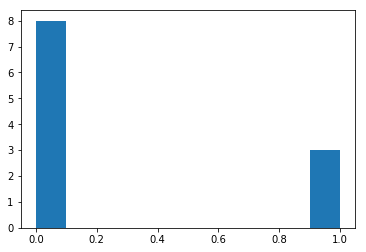

In [31]:
plt.hist(predictions)

In [20]:
predictions

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)